In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torch.autograd import Variable
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset,DataLoader
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from skimage import io

In [258]:
classs = { 0: "Speed limit (20km/h)", 
           1: "Speed limit (30km/h)", 
           2: "Speed limit (50km/h)", 
           3: "Speed limit (60km/h)", 
           4: "Speed limit (70km/h)", 
           5: "Speed limit (80km/h)",
           6: "End of Speed limit (80km/h)", 
           7: "Speed limit (100km/h)", 
           8: "Speed limit (120km/h)",
           9: "No passing", 
           10: "No passing veh over 3.5 tons", 
           11: "Right-of-way at intersection",
           12: "Priority road", 
           13: "Yield", 
           14: "Stop", 
           15: "No vehicles", 
           16: "Veh > 3.5 tons prohibited",
           17: "No entry", 
           18: "General caution", 
           19: "Dangerous curve left", 
           20: "Dangerous curve right", 
           21: "Double curve", 
           22: "Bumpy road", 
           23: "Slippery road", 
           24: "Road narrows on the right",
           25: "Road work", 
           26: "Traffic signals", 
           27: "Pedestrians", 
           28: "Children crossing", 
           29: "Bicycle crossing",
           30: "Beware of ice/snow", 
           31: "Wild animals crossing", 
           32: "End speed + passing limits", 
           33: "Turn right ahead", 
           34: "Turn left ahead", 
           35: "Ahead only", 
           36: "Go straight or right", 
           37: "Go straight or left", 
           38: "Keep right", 
           39: "Keep Left", 
           40: "Roundabout mandatory",
           41: "End of no passing", 
           42: "End of no passing veh > 3.5 tons"}


In [259]:
train_csv = pd.read_csv('archive-2/Train.csv')
test_csv = pd.read_csv('archive-2/Test.csv')

In [260]:
train_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [261]:
test_csv.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [262]:
my_path = 'archive-2/'
training_images_path = list(my_path + train_csv['Path'])
testing_images_path = list(my_path + test_csv['Path'])

training_labels = list(train_csv['ClassId'])
testing_labels = list(test_csv['ClassId'])

train_df = pd.DataFrame(data = {'Path':training_images_path,'Labels':training_labels})
test_df = pd.DataFrame(data = {'Path':testing_images_path,'Labels':testing_labels})


In [263]:
train_df.head()

,Path,Labels
0,archive-2/Train/20/00020_00000_00000.png,20
1,archive-2/Train/20/00020_00000_00001.png,20
2,archive-2/Train/20/00020_00000_00002.png,20
3,archive-2/Train/20/00020_00000_00003.png,20
4,archive-2/Train/20/00020_00000_00004.png,20


In [264]:
test_df.head()

,Path,Labels
0,archive-2/Test/00000.png,16
1,archive-2/Test/00001.png,1
2,archive-2/Test/00002.png,38
3,archive-2/Test/00003.png,33
4,archive-2/Test/00004.png,11


In [265]:
def showImagesAndLabal(indax):
    plt.imshow(Image.open(train_df["Path"][indax]))
    print(train_df["Labels"][indax])

4


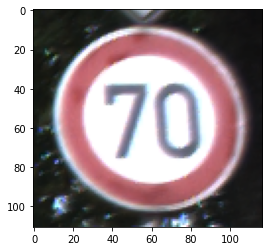

In [266]:
showImagesAndLabal(8009)

In [267]:

class Custom_TestDataset(Dataset):
  def __init__(self,dataframe,transform = None):
    self.dataframe = dataframe
    self.transform = transform

  def __len__(self):
      return self.dataframe.shape[0]

  def __getitem__(self, indax):
      image = self.dataframe.iloc[indax]["Path"]
      image = Image.open(image)

      if self.transform:
          image = self.transform(image)
      labal = int(self.dataframe.iloc[indax]["Labels"])
      return  torch.tensor(image), torch.tensor(labal)

In [268]:
data_transforms = {
    'Train': transforms.Compose([transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [269]:
image_train_datasets = Custom_TestDataset(dataframe=train_df,transform=data_transforms['Train'])
train_dataloaders = DataLoader(image_train_datasets, batch_size=32, shuffle=True)

image_test_datasets = Custom_TestDataset(dataframe=test_df,transform=data_transforms['Test'])
test_dataloaders = DataLoader(image_test_datasets, batch_size=32, shuffle=False)

print("the longth for train: {}".format(len(train_dataloaders)))
print("the longth for test: {}".format(len(test_dataloaders)))

the longth for train: 1226
the longth for test: 395


In [270]:
model_conv = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [271]:
lt=8
cntr=0

for child in model_conv.children():
  cntr+=1
  if cntr < lt:
	  for param in child.parameters():
		  param.requires_grad = False

In [272]:
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Sequential(
        nn.BatchNorm1d(num_ftrs),
        nn.Dropout(p=0.25),
        nn.Linear(in_features = num_ftrs, out_features = 2048),
        nn.ReLU(),
        nn.BatchNorm1d(2048),
        nn.Dropout(p=0.5),
        nn.Linear(in_features = 2048, out_features = 43))

In [273]:
if torch.cuda.is_available():
    model_conv = model_conv.cuda()

In [274]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model_conv.parameters()), lr=0.0001)

In [275]:
epochs = 35
train_error = []
train_acrr = []
test_acrr = []
for epoch in range(epochs):
    train_correct = 0 
    model_conv.train()
    for images,labels in train_dataloaders:

        images = Variable(images)
        labels = Variable(labels)

        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        optimizer.zero_grad()
        outpots = model_conv(images)
        loss = criterion(outpots,labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outpots,1)
        train_correct += (predicted == labels).sum().item()

    model_conv.eval()  
    with torch.no_grad():
      test_correct = 0
      for images,labels in test_dataloaders:
        
          if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            
          outputs = model_conv(images)                            
          _, predicted = torch.max(outputs, 1)
          test_correct += (predicted == labels).sum().item()

    train_accuracy = 100 * train_correct / len(image_train_datasets)
    test_accuracy = 100 * test_correct / len(image_test_datasets)
    train_acrr.append(train_accuracy)
    test_acrr.append(test_accuracy)
    train_error.append(loss.item())
    print("epoch [{}/{}], loss: {:.4f}, train accuracy: {:.2f}%, test accuracy: {:.2f}%".format(epoch+1,epochs,loss.item(),train_accuracy,test_accuracy))
    state = {'epoch':epoch,'model':model_conv,'error':train_error,'train accuracy':train_acrr,'test accuracy':test_acrr}
    torch.save(state , "finel model " +  str(epoch) + ".tar")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()


epoch [1/35], loss: 0.1075, train accuracy: 86.30%, test accuracy: 91.20%
epoch [2/35], loss: 0.0032, train accuracy: 97.90%, test accuracy: 91.18%
epoch [3/35], loss: 0.0231, train accuracy: 98.80%, test accuracy: 92.03%
epoch [4/35], loss: 0.0977, train accuracy: 99.01%, test accuracy: 92.11%
epoch [5/35], loss: 0.0025, train accuracy: 99.28%, test accuracy: 91.98%
epoch [6/35], loss: 0.0045, train accuracy: 99.31%, test accuracy: 92.82%
epoch [7/35], loss: 0.0007, train accuracy: 99.35%, test accuracy: 93.10%
epoch [8/35], loss: 0.0004, train accuracy: 99.53%, test accuracy: 92.37%
epoch [9/35], loss: 0.0046, train accuracy: 99.46%, test accuracy: 92.53%
epoch [10/35], loss: 0.2339, train accuracy: 99.61%, test accuracy: 92.59%
epoch [11/35], loss: 0.2634, train accuracy: 99.61%, test accuracy: 93.40%
epoch [12/35], loss: 0.0509, train accuracy: 99.56%, test accuracy: 93.46%
epoch [13/35], loss: 0.0001, train accuracy: 99.69%, test accuracy: 92.88%
epoch [14/35], loss: 0.7431, train

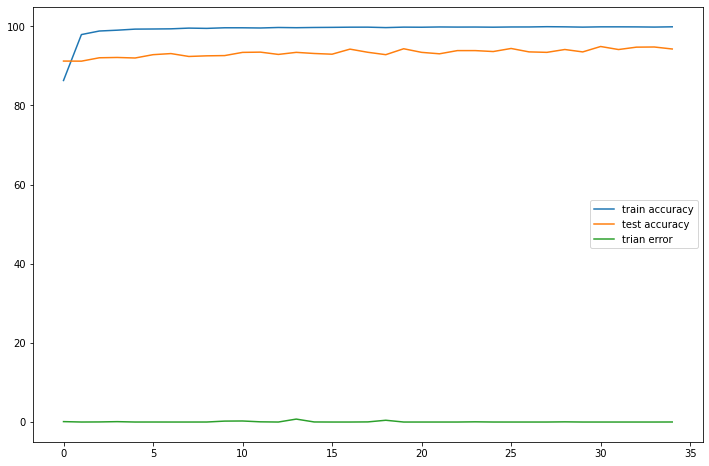

In [7]:

plt.figure(figsize=(12,8))

plt.plot(range(0,35),train_acrr,label = "train accuracy")
plt.plot(range(0,35),test_acrr,label = "test accuracy")
plt.plot(range(0,35),train_error,label = "trian error")

plt.legend()
plt.show()